<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [37]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [38]:
#root git folder 
name_model="vae_test"
path_second_folder = %pwd #"/home/goubetcle/Documents/Git/VAE/"
save_path = os.path.join(path_second_folder,"Results")#"/home/goubetcle/Documents/VAE/"
log_dir_model=os.path.join(save_path,"logs")
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [39]:
import importlib

sys.path.append(path_second_folder+'/src')

#import models, loss_class, params_class,AE_blocks,metrics
from src.models import *
#importlib.reload(models)
from src.loss_class import *
#importlib.reload(loss_class)
from src.params_class import *
#importlib.reload(params_class)
import src.AE_blocks
#importlib.reload(AE_blocks)
from src.metrics import *
#importlib.reload(metrics)
from src.utils import *


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [40]:
# Load dataframe
dataset_csv = os.path.join('data', "data_conso_2012-2021.parquet.brotli")
df_data = pd.read_parquet(dataset_csv)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

,utc_datetime,Consommation,prevision_j,prevision_j-1,prevision_neb,prevision_temp,is_holidays
157819,2020-12-31 21:30:00+00:00,64423.0,63700.0,64400.0,3.400764,2.328079,0.0
157820,2020-12-31 22:00:00+00:00,63505.0,63200.0,63800.0,3.479000,2.164250,0.0
157821,2020-12-31 22:30:00+00:00,64331.0,65200.0,65800.0,3.490986,2.029558,0.0
157822,2020-12-31 23:00:00+00:00,66853.0,67000.0,67500.0,3.369000,1.950550,0.0
157823,2020-12-31 23:30:00+00:00,66750.0,67200.0,67600.0,3.045322,1.953771,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [41]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

minute,0,30,60,90,120,150,180,210,240,270,...,1140,1170,1200,1230,1260,1290,1320,1350,1380,1410
days,,,,,,,,,,,,,,,,,,,,,
2012-01-01,58315.0,58315.0,56231.0,56075.0,55532.0,54911.0,52496.0,50664.0,49161.0,47596.0,...,57333.0,57786.0,57752.0,56946.0,56054.0,54975.0,53890.0,54348.0,56577.0,55634.0
2012-01-02,55164.0,53643.0,51404.0,50842.0,50399.0,50113.0,48201.0,47182.0,46306.0,46294.0,...,73263.0,72615.0,71079.0,69050.0,67435.0,65332.0,63756.0,64030.0,65929.0,64902.0
2012-01-03,64600.0,63033.0,60533.0,60426.0,60104.0,59861.0,57915.0,56691.0,55743.0,55656.0,...,76698.0,75660.0,73535.0,71275.0,69189.0,66829.0,64861.0,64898.0,66939.0,65479.0
2012-01-04,65081.0,63129.0,60564.0,60194.0,59709.0,59353.0,57569.0,56545.0,55655.0,55628.0,...,78337.0,77173.0,75281.0,72985.0,70927.0,68726.0,66808.0,66878.0,68550.0,67376.0
2012-01-05,67042.0,65123.0,62447.0,62331.0,61889.0,61501.0,59574.0,58245.0,57258.0,56923.0,...,78351.0,76928.0,74868.0,72432.0,70197.0,68036.0,66269.0,66070.0,68169.0,66910.0


In [42]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

minute,0,30,60,90,120,150,180,210,240,270,...,1140,1170,1200,1230,1260,1290,1320,1350,1380,1410
days,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.306926,0.306926,0.135886,0.123082,0.078516,0.027549,-0.170658,-0.321017,-0.444373,-0.572818,...,0.226330,0.263510,0.260719,0.194568,0.121359,0.032801,-0.056248,-0.018659,0.164283,0.086888
2012-01-02,0.048313,-0.076520,-0.260282,-0.306408,-0.342766,-0.366239,-0.523163,-0.606796,-0.678692,-0.679677,...,1.533758,1.480575,1.354510,1.187984,1.055435,0.882835,0.753487,0.775975,0.931833,0.847543
2012-01-03,0.822757,0.694148,0.488965,0.480183,0.453756,0.433812,0.274097,0.173639,0.095834,0.088693,...,1.815680,1.730488,1.556082,1.370597,1.199392,1.005699,0.844178,0.847215,1.014727,0.894900
2012-01-04,0.862234,0.702027,0.491509,0.461142,0.421337,0.392118,0.245700,0.161657,0.088611,0.086395,...,1.950198,1.854665,1.699382,1.510942,1.342035,1.161392,1.003975,1.009720,1.146947,1.050593
2012-01-05,1.023180,0.865682,0.646053,0.636533,0.600256,0.568412,0.410257,0.301181,0.220175,0.192680,...,1.951348,1.834557,1.665486,1.465555,1.282122,1.104761,0.959738,0.943405,1.115677,1.012347


Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [43]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)


,ds,month,weekday,is_weekend,year,is_holiday_day
0,2012-01-01,1,6,1,2012,1.0
1,2012-01-02,1,0,0,2012,0.0
2,2012-01-03,1,1,0,2012,0.0
3,2012-01-04,1,2,0,2012,0.0
4,2012-01-05,1,3,0,2012,0.0


In [44]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [45]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean]
factorDesc['temperature']='regressor'

# Tools to evaluate the representations

In [46]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [47]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [48]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE ou CVAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)
- les dimensions de notre embedding des conditions dans le cas dans CVAE

In [49]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [50]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [51]:
#on va conditionner sur les profils de température et le mois
calendar_cond = ["weekday"]
condtovae_dims = []
condarray=[]

df_temp, _ = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])

In [52]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [53]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [55]:
vae_params.model_params.encoder_dims = [e_dims]*(len(condtovae_dims)+1)
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.input_dims = [df_conso.shape[1]] + condtovae_dims

vae_params.model_params.nb_encoder_ensemble = 1

In [56]:
#example of custom loss definition

loss_weights = {"recon_loss" : 10,
                "kl_loss" : 0.1,
                "info_loss" : 66}

vae_loss = VAELoss(loss_weights = loss_weights, custom_loss=None) #change None to custom_loss if will to use one
vae_loss.options["log_prior_sigma"] = [-1.,0.,1.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [57]:
new_cae=GuidedCVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/Git/VAE/Results/logs/vae_test',
 'model_params': <src.params_class.VAEModelParams at 0x7f14053cbe50>,
 'training_params': <src.params_class.VAETrainingParams at 0x7f1460032190>}

In [62]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_0 (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 inputs_1 (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 inputs_2 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 guided_encoder (Functional)    [(None, 4),          16804       ['inputs_0[0][0]',               
                                 (None, 4)]                       'inputs_1[0][0]',            

In [63]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
## END TRAINING ##


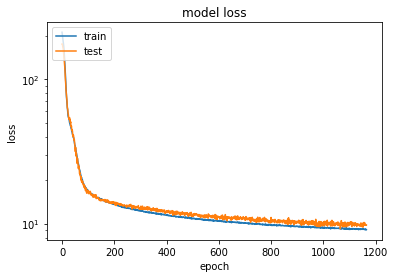

## MODEL SAVED ##


In [64]:
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae = [df_conso.values[train_set,:]] + [c[train_set,:] for c in condarray]
output_cvae = df_conso.values[train_set,:]

new_cae.train(input_cvae, output_cvae, epochs= 4000, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop])

## Evaluer l'importance et la qualité des embeggings appris

Nous allons voir:
- l'importance portée par des variables dans la représentation latente
- l'importance portée par des variables dans l'embedding conditionnel

Nous nous appuyons pour cela sur des score d'information, de démêlement, de compacité et de modularité

Nous devrions constater que des variables importante dans l'embedding conditionnel ne le sont plus dans la représentation latente: elles ont été factorisées

In [65]:
x_encoded = new_cae.encoder.predict(input_cvae)[0]

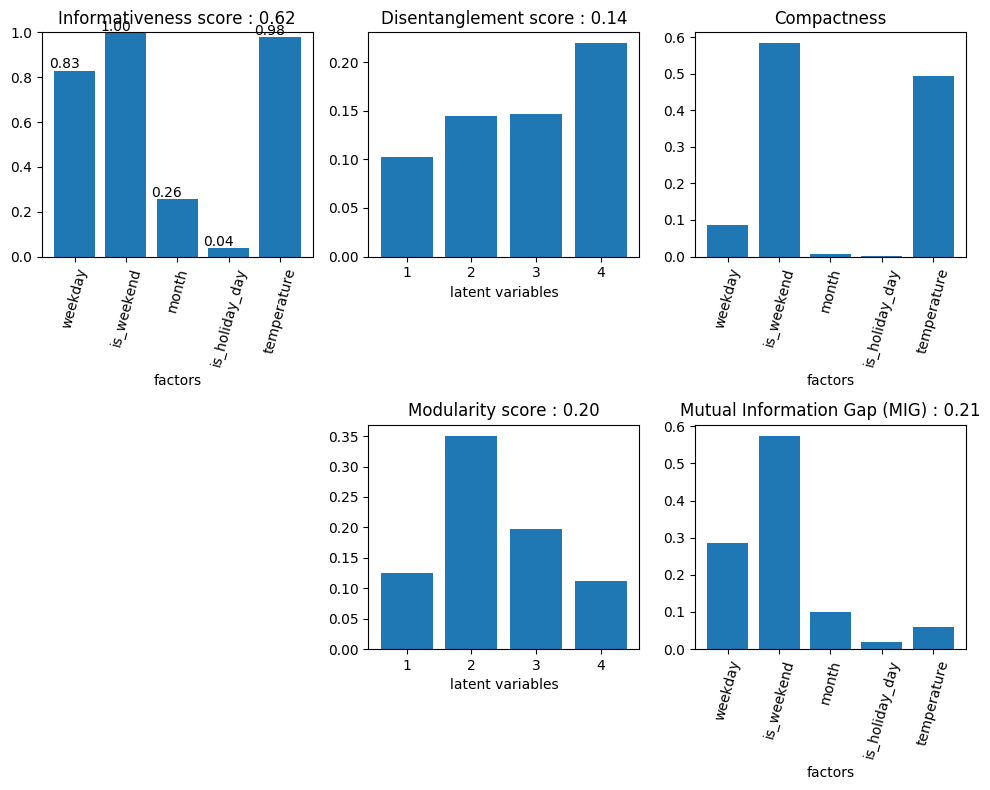

In [66]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [67]:
test_input_cvae = [df_conso.values[test_set,:]] + [c[test_set,:] for c in condarray]

x_hat = new_cae.model.predict(test_input_cvae)

np.mean(np.abs(x_hat - test_input_cvae[0]))

0.17405957286201051

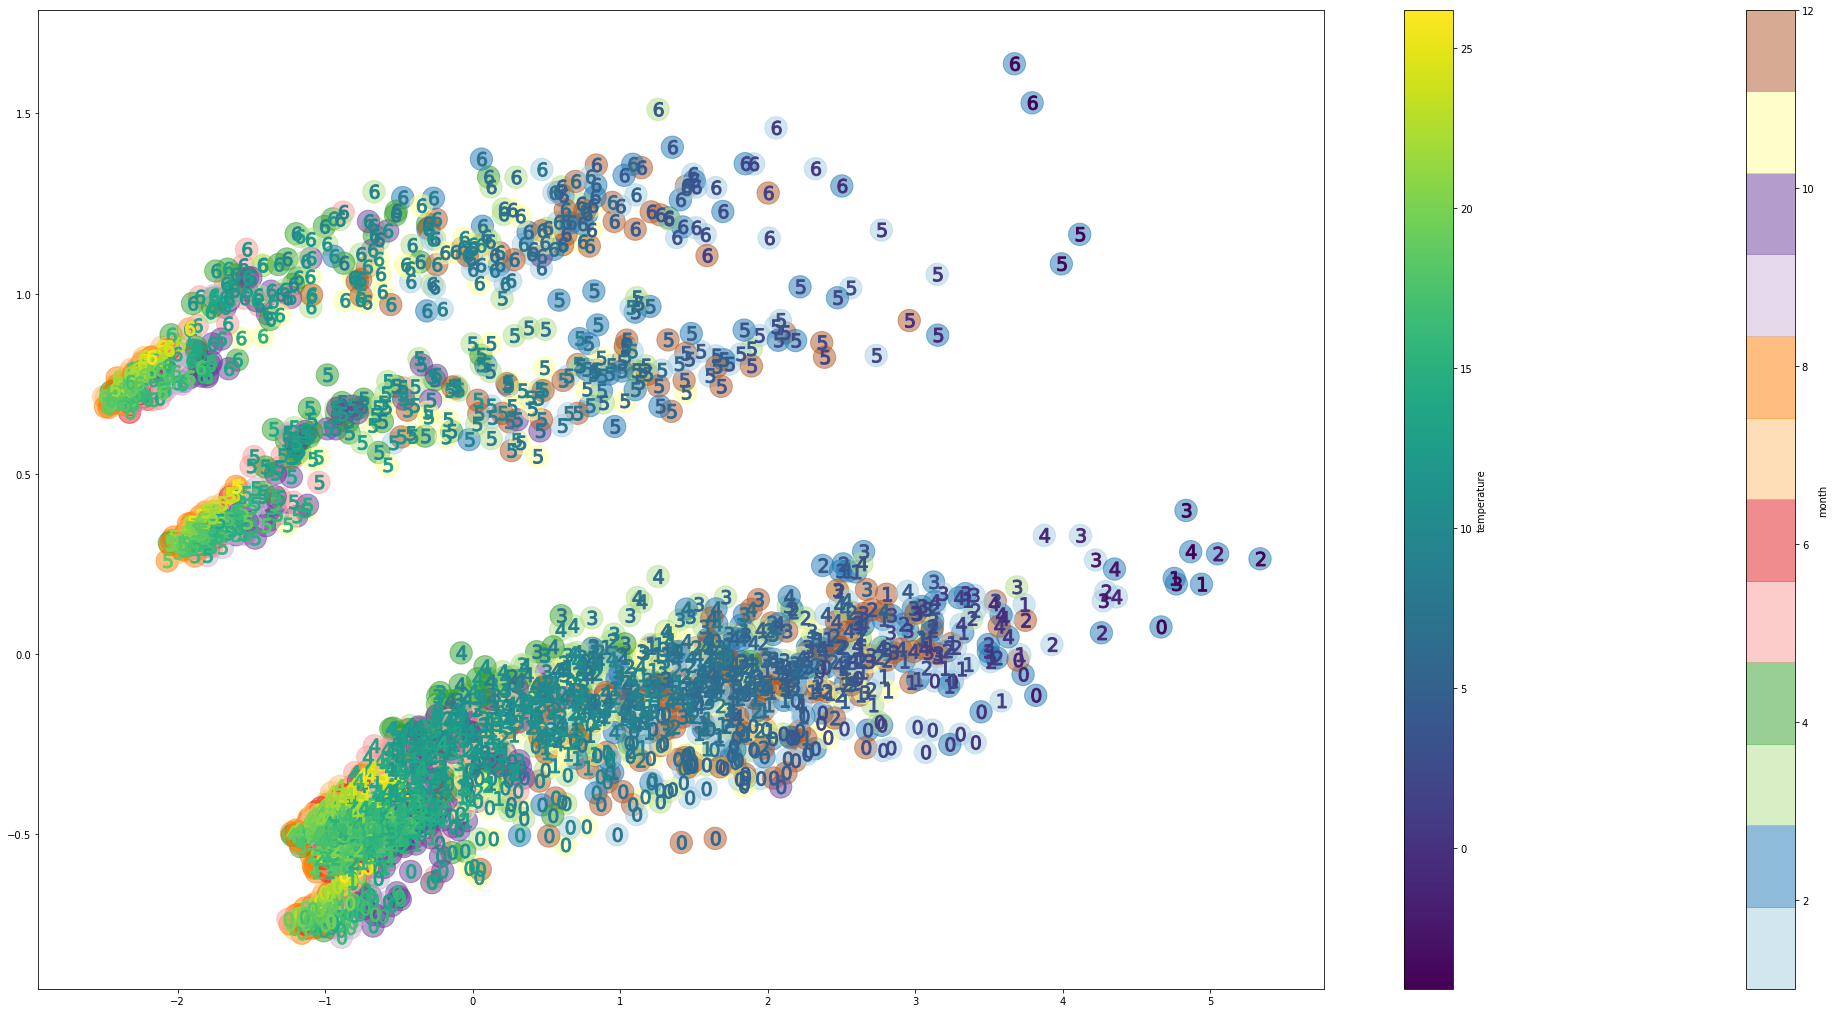

In [68]:
prez_2D(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])